# Problem Statement:

### In this homework assignment, we are going to use Cluster Analysis (K-Means & HAC) and Decision Tree induction algorithm on a weather forecast problem. It is a binary classification problem to predict whether or not a location will get rain the next day.

### Information about the dataset (Weather Forecast Training.csv):

• Location: The location name of the weather station

• MinTemp: The minimum temperature in degrees celsius

• MaxTemp: The maximum temperature in degrees celsius

• Rainfall: The amount of rainfall recorded for the day in mm

• Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am

• Sunshine: The number of hours of bright sunshine in the day.

• WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight

• WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight

• WindDir: Direction of the wind

• WindSpeed: Wind speed (km/hr) averaged over 10 minutes

• Humidity: Humidity (percent)

• Pressure: Atmospheric pressure (hpa) reduced to mean sea level

• Cloud: Fraction of sky obscured by cloud This is measured in “oktas”, which are a unit of eigths. It
records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky
whilst an 8 indicates that it is completely overcast.

• Temp: Temperature (degrees C)

• RainTodayBoolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

• RainTomorrow: The target variable. Did it rain tomorrow?

### Import Libraries

Importing all the required libraries that will help us perform data pre-processing, visualizations, modeling and performance evaluation.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series
import seaborn as sns
from fancyimpute import IterativeImputer
from scipy import stats
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,classification_report,recall_score,roc_curve,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn import datasets
from sklearn import tree

### Read dataset

- Here we are reading both the train and test data set. We will be performing all the data pre-processing steps on both the training and testing data set. 

- Later on, while modeling we will be splitting the training dataset into training and validation to train our model and perform hyper parameter tuning using the performance on validation set. 

- Finally, we will be using the model with best parameters to predict binary labels for the testing dataset.


In [2]:
# Reading both training and testing dataset
df=pd.read_csv('Weather Forecast Training.csv')
test_df = pd.read_csv('Weather Forecast Testing.csv')

In [3]:
# Check the shape of the train data
df.shape

(51978, 16)

In [4]:
# Check the shape of the test data
test_df.shape

(12994, 16)

In [5]:
# View first few data points of training data
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No


In [6]:
# Check the data type for each of the attributes of training data
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object

### Data Pre-processing & Exploratory Data Analysis

#### Here, we have followed the CRISP-DM methodology  which consists of following steps in the mentioned order: Business & Data Understanding -> Data cleaning & Pre-processing -> Modeling -> Performance Evaluation 

We have addressed the following data issues here while performing the data pre-processing:

1) Remove irrelevant columns

2) Handling outliers

3) Checking highly correlated columns

4) Find missing values and impute them accordingly


#### 1) Remove irrelevant columns
- Here, firstly we check for the percent of missing values present in both of our training and testing dataset. 

- As we can see below, there are 3 attributes in particular - 'Evaporation', 'Sunshine', 'Cloud' - all of them contain more than 39% missing values. Imputing such a large percentage of values in these attributes will not be a good approach as it will eventually lead to bias in our model. 

- Hence, we have dropped these 3 attributes from both of our training data and test data.

In [7]:
# Check for % of missing values in training data
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

Location          0.000000
MinTemp           0.546385
MaxTemp           0.248182
Rainfall          1.437146
Evaporation      43.389511
Sunshine         47.856786
WindGustDir       6.922159
WindGustSpeed     6.870214
WindDir           2.910847
WindSpeed         1.970064
Humidity          2.749240
Pressure          9.746431
Cloud            38.727923
Temp              2.045096
RainToday         1.437146
RainTomorrow      0.000000
dtype: float64


In [8]:
# Check for % of missing values in testing data
percent_missing = test_df.isnull().sum() * 100 / len(test_df)
print(percent_missing)

ID                0.000000
Location          0.000000
MinTemp           0.361705
MaxTemp           0.138525
Rainfall          1.239033
Evaporation      42.450362
Sunshine         46.898569
WindGustDir       7.149454
WindGustSpeed     7.080191
WindDir           2.978298
WindSpeed         2.008619
Humidity          2.685855
Pressure          9.950746
Cloud            38.633215
Temp              2.054795
RainToday         1.239033
dtype: float64


#### Dropping all the 3 attributes that contain around 43%, 48% and 39% of missing values in both training data and testing data

In [9]:
# Dropping attributes from training data
del df['Evaporation']
del df['Sunshine']
del df['Cloud']

# Dropping attributes from testing data
del test_df['Evaporation']
del test_df['Sunshine']
del test_df['Cloud']

#### 2) Handling outliers
- Checking for outliers in the data set and treating them accordingly is one of the major steps of pre-processing in order to achieve a higher model performance. 

- Here, we have used the box plot visualizations for the numerical attributes which will help us identify outliers present in the dataset.

- The below visualizations represent that most of the numerical attributes present in the training data contain outliers. We will be using the clipping technique to deal with the outliers present in the dataset. 

- Clipping technique involves checking for all the values present in an attribute and identifying which all values lie outside the range that we have provided for clipping. Here, we will be using the lower bound as the 5th percentile and upper bound as the 95th percentile. 

- All the values for each of the attributes that lie outside these two interval will be clipped and modified to the 5th and the 95th percentile value accordingly.


#### Below, we have boxplots of all of our numerical attributes against the target variable i.e. RainTomorrow.

Text(0.5, 1.0, 'Box plot of MinTemp vs RainTomorrow')

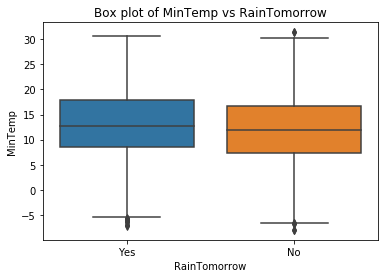

In [10]:
# Boxplot of MinTemp attribute vs target attribute RainTomorrow
sns.boxplot(y="MinTemp", x="RainTomorrow", data=df)
plt.title("Box plot of MinTemp vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of MaxTemp vs RainTomorrow')

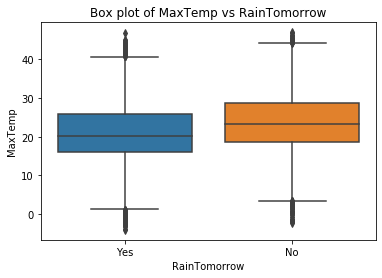

In [11]:
# Boxplot of MaxTemp attribute vs target attribute RainTomorrow
sns.boxplot(y="MaxTemp", x="RainTomorrow", data=df)
plt.title("Box plot of MaxTemp vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of Rainfall vs RainTomorrow')

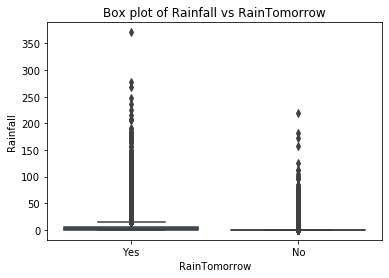

In [12]:
# Boxplot of Rainfall attribute vs target attribute RainTomorrow
sns.boxplot(y="Rainfall",x='RainTomorrow', data=df)
plt.title("Box plot of Rainfall vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of WindGustSpeed vs RainTomorrow')

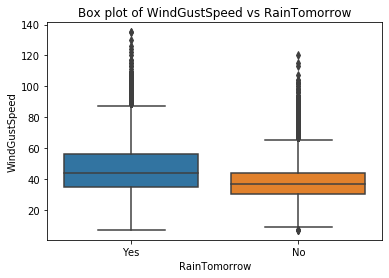

In [13]:
# Boxplot of WindGustSpeed attribute vs target attribute RainTomorrow
sns.boxplot(y="WindGustSpeed", x="RainTomorrow", data=df)
plt.title("Box plot of WindGustSpeed vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of WindSpeed vs RainTomorrow')

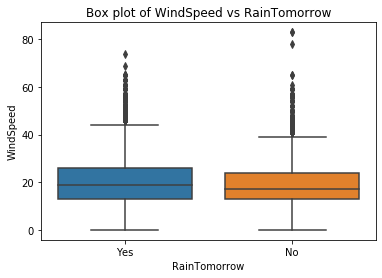

In [14]:
# Boxplot of WindSpeed attribute vs target attribute RainTomorrow
sns.boxplot(y="WindSpeed", x="RainTomorrow", data=df)
plt.title("Box plot of WindSpeed vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of Humidity vs RainTomorrow')

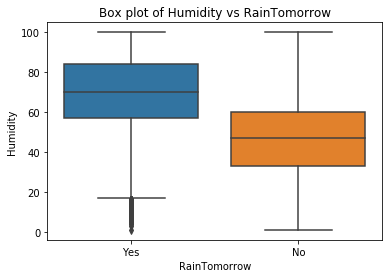

In [15]:
# Boxplot of Humidity attribute vs target attribute RainTomorrow
sns.boxplot(y="Humidity", x="RainTomorrow", data=df)
plt.title("Box plot of Humidity vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of Pressure vs RainTomorrow')

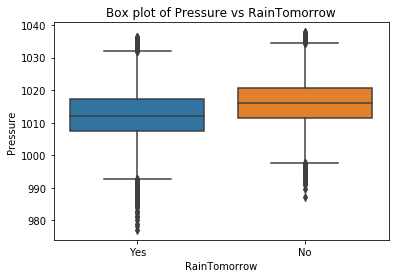

In [16]:
# Boxplot of Pressure attribute vs target attribute RainTomorrow
sns.boxplot(y="Pressure", x="RainTomorrow", data=df)
plt.title("Box plot of Pressure vs RainTomorrow")

Text(0.5, 1.0, 'Box plot of Temp vs RainTomorrow')

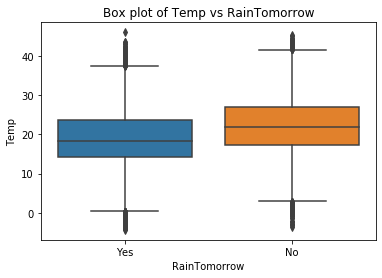

In [17]:
# Boxplot of Temp attribute vs target attribute RainTomorrow
sns.boxplot(y="Temp", x="RainTomorrow", data=df)
plt.title("Box plot of Temp vs RainTomorrow")

#### Treating the outliers by clipping all the data points for each of the numerical attributes that lie outside the lower bound (5th percentile) and upper bound (95th percentile) to the values present at the 5th and 95th percentile accordingly

In [18]:
# Clipping the outliers for the below attributes according to the values present at the 5th and the 95th percentile
cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed', 'Humidity', 'Pressure', 'Temp']
df[cols] = df[cols].clip(lower=df[cols].quantile(0.05), upper=df[cols].quantile(0.95), axis=1)

#### 3) Checking highly correlated columns & distribution of the target attribute 

- Here, we will be using the correlation plot to check the correlation between all the attributes present in the dataset. Correlation matrix will give us idea about the highly correlated features. This will be beneficial for us later on while doing imputation for the missing values and also help us in dropping an attribute if it is highly correlated with any other attribute. 

- Before we plot the correlation matrix, we will convert the values present in attributes - 'RainToday' & 'RainTomorrow' - from string type (Yes/No) to integer type (1/0). 

- From the below correlation plot, we can infer that some of the attributes are highly correlated, for example - 'MaxTemp' & 'Temp'; 'MaxTemp' & 'MinTemp' and 'MinTemp' & 'Temp'

- We will also plot the distribution plot for the target feature - 'RainTomorrow' - this will help us get an idea of whether our dataset contains an equal distribution for both the labels -1/0 - for the target attribute. Below plot shows us that the target feature contains an almost equal number of labels for both the classes - 1/0

In [19]:
# Replacing Yes/No with 1/0 for attributes - 'RainToday' & 'RainTomorrow' - in training data
df['RainToday'] = df['RainToday'].map(dict(Yes=1, No=0))
df['RainTomorrow'] = df['RainTomorrow'].map(dict(Yes=1, No=0))



In [20]:
# Replacing Yes/No with 1/0 for attribute - 'RainToday' - in testing data
test_df['RainToday'] = test_df['RainToday'].map(dict(Yes=1, No=0))

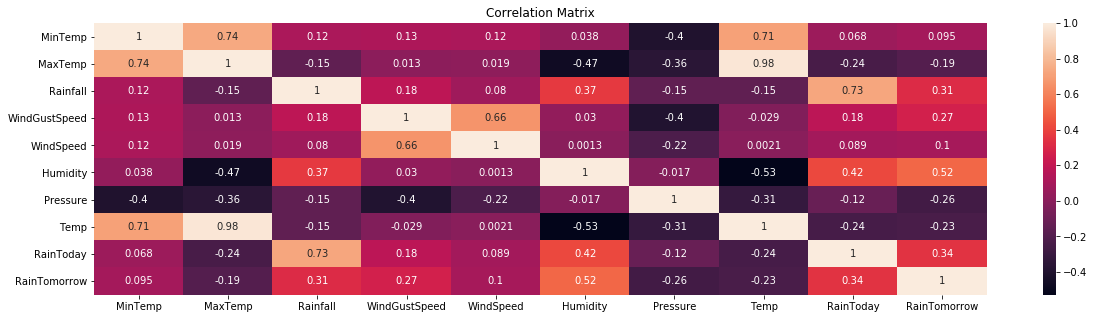

In [21]:
# Ploting correlation matrix heatmap
plt.figure(figsize=(20,5))
plt.title("Correlation Matrix")
sns.heatmap(df.corr(),annot=True)

Text(0.5, 1.0, 'Distribution of RainTomorrow for our dataset')

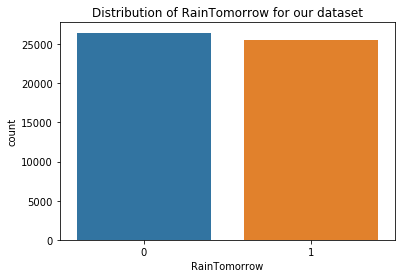

In [22]:
# Countplot to check the distribution of labels in attribute - 'RainTommorow'
sns.countplot(x="RainTomorrow", data=df).set_title('Distribution of RainTomorrow for our dataset')

#### 4) Data Imputation
Data imputation is one of the most important step involved in data pre-processing. As our training dataset contains a large number of missing values, it is really necessary for us to impute them according to the best possible techniques. Here, we have followed the methods mentioned below in order to perform data imputations for the missing values:

- Firstly, we check for the total number of missing values present in both the training data and testing data

- Secondly, we will check for all the categorical features that contain missing values. Below, we have plotted the distribution plots for all the catagorical features for both of our training set and testing set to get a measure of the spread of the categorical data. We will be using the mode values for the categorical features and fill up all the missing values using the mode values. Below plots show that the mode value for 'WindGustDir' is West for both the training and testing data. So, we have imputed the missing values for 'WindGustDir' with 'W' in both the training and testing set. Similarly, we have imputed the missing values for 'WindDir' with the mode value 'W' in both the datasets. 'RainToday' is also a categorical feature that has been converted by us into a numerical feature. We have checked for the distribution of 'RainToday' for both the train and test data and we can see that the mode value for this feature is 'No' or 0. So, we have imputed the missing values for RainToday in both the dataset with a value of 0 indicating that the precipitation for all these days have not exceeded 1mm.

- Thirdly, we check for the attributes that have high correlation among them as this will help us to impute the missing values. Below, we have plotted the correlation matrix for all the features where the absolute correlation value among the attributes is >0.7 . From the plot we can infer that the correlation between 'MaxTemp' and 'Temp' is really high (0.98). So, we will be using the values present in 'Temp' to impute the corresponding missing values present in the 'MaxTemp' attribute. We will be doing the same for both the train and test data. After the imputation, we will be dropping the column 'Temp' as it has very high correlation with 'MaxTemp'.

- Finally, we will be using the technique known as MICE (Multiple Imputations By Chained Equations) for imputing all the remaining missing values present in our numerical attributes. The fancyimpute package in Python consists of several algorithms like KNN (K-nearest neighbours) & MICE - that can help us in imputing missing values 

- MICE uses the following steps for imputing missing values:
                        - Perform multiple regressions over random sample of the data 
                        - Take average of the multiple regression values
                        - Impute the missing feature value for the data point
                        
- Here, we have used MICE over KNN as MICE is more robust than KNN. Moreover, we tried using KNN instead of MICE for imputing the remaining missing values and then implemented our machine learning models. The model's performance showed a decrease in Accuracy, Precision & Recall when imputation was done using KNN as compared to the imputation done using MICE.

In [23]:
# Check total null values present for all attributes in training data
df.isnull().sum()

Location            0
MinTemp           284
MaxTemp           129
Rainfall          747
WindGustDir      3598
WindGustSpeed    3571
WindDir          1513
WindSpeed        1024
Humidity         1429
Pressure         5066
Temp             1063
RainToday         747
RainTomorrow        0
dtype: int64

In [24]:
# Check total null values present for all attributes in testing data
test_df.isnull().sum()

ID                  0
Location            0
MinTemp            47
MaxTemp            18
Rainfall          161
WindGustDir       929
WindGustSpeed     920
WindDir           387
WindSpeed         261
Humidity          349
Pressure         1293
Temp              267
RainToday         161
dtype: int64

##### Imputing categorical attributes - 'WindGustDir', 'WindDir', 'RainToday' - with mode values for both train and test dataset

Text(0.5, 1.0, 'Distribution of WindGusDir for our dataset')

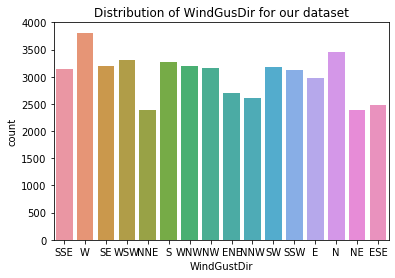

In [25]:
# Distribution plot for 'WindGustDir' for training data
sns.countplot(x="WindGustDir", data=df).set_title('Distribution of WindGusDir for our dataset')

Text(0.5, 1.0, 'Distribution of WindGusDir for our test dataset')

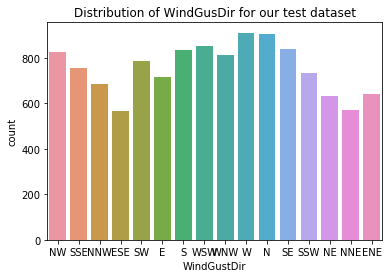

In [26]:
# Distribution plot for 'WindGustDir' for testing data
sns.countplot(x="WindGustDir", data=test_df).set_title('Distribution of WindGusDir for our test dataset')

In [27]:
# Imputing missing values for 'WindGusDir' with mode value 'W' for both train and test data
df.WindGustDir = df.WindGustDir.fillna('W')
test_df.WindGustDir = test_df.WindGustDir.fillna('W')

Text(0.5, 1.0, 'Distribution of WindDir for our dataset')

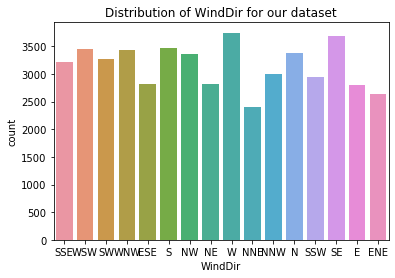

In [28]:
# Distribution plot for 'WindDir' for training data
sns.countplot(x="WindDir", data=df).set_title('Distribution of WindDir for our dataset')

Text(0.5, 1.0, 'Distribution of WindDir for our test dataset')

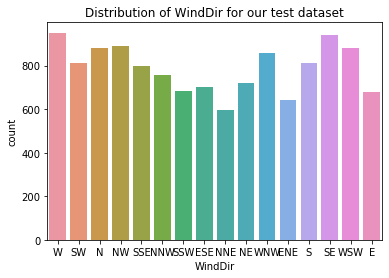

In [29]:
# Distribution plot for 'WindDir' for testing data
sns.countplot(x="WindDir", data=test_df).set_title('Distribution of WindDir for our test dataset')

In [30]:
# Imputing missing values for 'WindDir' with mode value 'W' for both train and test data
df.WindDir = df.WindDir.fillna('W')
test_df.WindDir = test_df.WindDir.fillna('W')

Text(0.5, 1.0, 'Distribution of RainToday for our dataset')

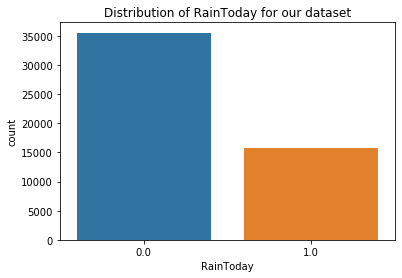

In [31]:
# Distribution plot for 'RainToday' for training data
sns.countplot(x="RainToday", data=df).set_title('Distribution of RainToday for our dataset')

Text(0.5, 1.0, 'Distribution of RainToday for our test dataset')

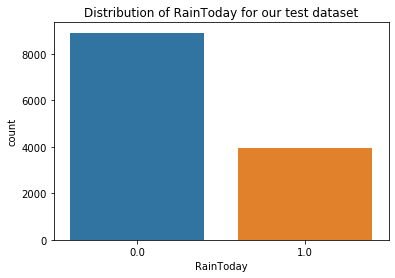

In [32]:
# Distribution plot for 'RainToday' for testing data
sns.countplot(x="RainToday", data=test_df).set_title('Distribution of RainToday for our test dataset')

In [33]:
# Imputing missing values for 'RainToday' with mode value '0' for both train and test data
df.RainToday = df.RainToday.fillna('0')
test_df.RainToday = test_df.RainToday.fillna('0')

#### Plotting correlation matrix plot for all attributes where absolute vaue of correlation is > 0.7

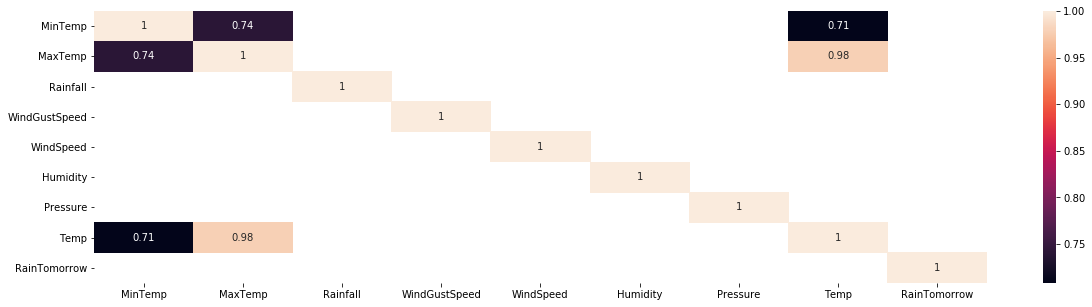

In [34]:
#Below we plot a correlation matrix which has absolute correlation value greater than 0.7
plt.figure(figsize=(20,5))
sns.heatmap(df.corr()[abs(df.corr())>.7],annot=True);

#### As the attributes 'MaxTemp' and 'Temp' have a very high correlation vaue of 0.98, we will be imputing the missing values in 'MaxTemp' with the corresponding values in 'Temp'. After the imputation, we have dropped the 'Temp' attribute as it is strongly correlated with 'MaxTemp'

In [35]:
# Imputing the missing values in MaxTemp with the corresponding values in Temp and dropping the Temp attribute for training data
df['MaxTemp'] = df.apply(lambda row: row['Temp'] if np.isnan(row['MaxTemp']) else row['MaxTemp'],axis=1)
df.drop("Temp",inplace=True,axis=1)

In [36]:
# Doing the same for testing data
test_df['MaxTemp'] = test_df.apply(lambda row: row['Temp'] if np.isnan(row['MaxTemp']) else row['MaxTemp'],axis=1)
test_df.drop("Temp",inplace=True,axis=1)

#### Using fancyimpute package's MICE algorithm to impute all the remaining missing values present in all the numerical attributes

In [37]:
# Implementing MICE imputer
MICE_imputer = IterativeImputer()

In [38]:
# Imputing missing values for all the numerical attributes using MICE for the training dataset
df.iloc[:, [1,2,3,5,7,8,9]] = MICE_imputer.fit_transform(df.iloc[:, [1,2,3,5,7,8,9]])

In [39]:
# Doing MICE imputation for testing dataset
test_df.iloc[:, [2,3,4,6,8,9,10]] = MICE_imputer.fit_transform(test_df.iloc[:, [2,3,4,6,8,9,10]])

#### Finally, we check for the sum of missing values for both the training and testing data and we can see that there are no missing values present for both

In [40]:
# Checking final sum of missing values for training data
df.isna().sum().sum()

0

In [41]:
# Checking final sum of missing values for testing data
test_df.isna().sum().sum()

0

## Modeling

## K-Means Clustering Model

Repurposing the unsupervised cluster based algorithm for classification problem: 

We have repurposed the unsupervised algorithm by tuning the model to form 2 clusters that will help us to predict the two output labels - 1 or 0 for the rain forecast. Generally, we do not have true labels present while using unsupervised algorithms. But here we have the output labels present in our training data set. So, we can use them to fine tune our model and evaluate how well it is performing on the task of predicting rain labels.  

Performing K-means algorithm:
- Firstly, we have created a copy of our pre-processed train and test dataset for the K-means model. We have removed all the categorical attributes as doing a One-hot encoding for K-means algorithm will not be beneficial. This is due to the fact that binary coding will produce high density regions which will affect the performance of K-means model. We have dropped 'RainToday' attribute for the same reason. We have also dropped 'ID' attribute from the test data set.

- Then, we have split our data set into training and validation set to make sure that our model does not overfit on the training data.

- After this, we have scaled our columns between 0 and 1 using a MinMax scaler, so that all the features are on the same scale. This is one of the most important things that can impact the performance of kmeans clustering.

- We have fine tuned different hyperparameters using grid search. This has helped us to improve the performance of our model and eventually improve the metric scores and at the same time making sure that the model does not overfit on the training data. 

- For evaluating the performance of our model we have used the evaluation metric - Recall - as it is important for our model to predict the days with rainfall when it actually rained on that day

In [42]:
# Creating a copy of pre-processed train and test data that we will be using to implement K-Means
train_df_kmeans = df.copy()
test_df_kmeans = test_df.copy()

In [43]:
#Dropping all the categorical columns, 'RainToday' from the train and test data and dropping 'ID' from test data
train_df_kmeans.drop(["Location",'WindDir','WindGustDir','RainToday'],axis=1,inplace=True)
test_df_kmeans.drop(["Location",'WindDir','WindGustDir','RainToday', 'ID'],axis=1,inplace=True)

In [44]:
# Train-test split
X = train_df_kmeans.drop('RainTomorrow', axis=1)

In [45]:
# Train-test split
y = train_df_kmeans['RainTomorrow']

In [46]:
# Creating Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [47]:
# Using MinMax scalar
min_max_scaler_kmeans = preprocessing.MinMaxScaler()

In [48]:
# Scaling train data
X_train=min_max_scaler_kmeans.fit_transform(X_train)

In [49]:
# Scaling validation data
X_test=min_max_scaler_kmeans.transform(X_test)

In [50]:
# Scaling test data
test_df_kmeans=min_max_scaler_kmeans.transform(test_df_kmeans)

In [51]:
# Implementing Kmeans model with 2 clusters
kmeans_model = KMeans(n_clusters=2,random_state=0)

#### Hyper-parameter tuning using GridSearch:

- n_init: Number of times the model starts to run from a random centroid point.

- max_iter: Maximum number of iterations after which the model stops to optimize the centroids of the clusters. 



In [52]:
# Performing grid search to find the best hyper-parameters
param_grid_kmeans = {
              'n_init': [10,20,25,50],
              'max_iter': [10,20,50,100],
              }

# Using 10 fold cross validation and evaluation metric as Recall
grid_kmeans = GridSearchCV(kmeans_model, param_grid_kmeans, cv=10, scoring='recall')

# Fitting Kmeans model
grid_kmeans.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=2, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=0, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [10, 20, 50, 100],
                         'n_init': [10, 20, 25, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [53]:
# Printing the best hyper-parameters obtained from the grid search
grid_kmeans.best_params_

{'max_iter': 20, 'n_init': 50}

#### Interpreting the results
- Below we have classification reports for both the training set and the validation set

- We can infer from the classification reports that our K-Means model performs equally well on the training and testing data. It does not overfit on the training data

- The recall value is 0.54 which represents that our model is able to correctly predict rainfall 54% of the times when it actually rained on that day

- The performance of this model is not that good which can be traced back to the point that we had a large number of missing values present in our dataset in the first place

In [54]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(grid_kmeans.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54     22953
           1       0.56      0.54      0.55     23827

    accuracy                           0.55     46780
   macro avg       0.55      0.55      0.55     46780
weighted avg       0.55      0.55      0.55     46780



In [55]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(grid_kmeans.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.54      0.57      0.55      2538
           1       0.57      0.54      0.55      2660

    accuracy                           0.55      5198
   macro avg       0.55      0.55      0.55      5198
weighted avg       0.55      0.55      0.55      5198



In [56]:
# Predicting rain forecast labels for test dataset
test_prediction_kmeans = grid_kmeans.predict(test_df_kmeans)

## Decision Tree Model

Performing Decision Tree algorithm:

- Firstly, we have created a copy of our pre-processed train and test dataset to implement the Decision tree model. We have converted all the categorical features into numerical feartures using One-hot encoding

- After that, we have split our data into train and validation sets to evaluate the performance of our model.

- Then, we have used a 10 folds Grid Search to fine tune the hyperparameters which gives us the best recall.

- Here, we have used Recall as the evaluation metric. We want our model to have as high recall as possible. Recall is also known as sensitivity or the True positive rate. A higher recall indicates that our model correctly predicts most of days with rains when it actually rains on that day

- We have generated a plot for the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). This represents a plot of True positive rate against False positive rate and helps us to evaluate the performance of our model in a more superior way

- We have also generated a decision tree output visualization to interpret the DT model in a better way

In [57]:
# Creating a copy of pre-processed train and test data that we will be using to implement Decision tree model
train_df_dt = df.copy()
test_df_dt = test_df.copy()

In [58]:
# Converting categorical attribute 'Location' into numerical attribute using One-Hot encoding and then dropping the original 'Location' attribute. Doing the same for both train and test data
train_df_dt = pd.concat([train_df_dt,pd.get_dummies(train_df_dt['Location'], prefix='Location')],axis=1)
train_df_dt.drop(['Location'],axis=1, inplace=True)
test_df_dt = pd.concat([test_df_dt,pd.get_dummies(test_df_dt['Location'], prefix='Location')],axis=1)
test_df_dt.drop(['Location'],axis=1, inplace=True)

# Converting categorical attribute 'WindGustDir' into numerical attribute using One-Hot encoding and then dropping the original 'WindGustDir' attribute. Doing the same for both train and test data
train_df_dt = pd.concat([train_df_dt,pd.get_dummies(train_df_dt['WindGustDir'], prefix='WindGustDir')],axis=1)
train_df_dt.drop(['WindGustDir'],axis=1, inplace=True)
test_df_dt = pd.concat([test_df_dt,pd.get_dummies(test_df_dt['WindGustDir'], prefix='WindGustDir')],axis=1)
test_df_dt.drop(['WindGustDir'],axis=1, inplace=True)

# Converting categorical attribute 'WindDir' into numerical attribute using One-Hot encoding and then dropping the original 'WindDir' attribute. Doing the same for both train and test data
train_df_dt = pd.concat([train_df_dt,pd.get_dummies(train_df_dt['WindDir'], prefix='WindDir')],axis=1)
train_df_dt.drop(['WindDir'],axis=1, inplace=True)
test_df_dt = pd.concat([test_df_dt,pd.get_dummies(test_df_dt['WindDir'], prefix='WindDir')],axis=1)
test_df_dt.drop(['WindDir'],axis=1, inplace=True)

In [59]:
# Building model for decision tree algorithm
dt_clf=DecisionTreeClassifier(random_state=0)

In [60]:
# Creating the train validation split
X = train_df_dt.drop('RainTomorrow', axis=1)

y = train_df_dt['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### Hyper-paramater tuning using GridSearch:

- criterion: The criterion that will be used to split a node. This can be either gini index or entropy.

- min_samples_split: This ensures that a node is split only when a minimum number of samples are present in the node.

- max_depth: This is the maximum depth till which the tree will keep on splitting. It ensures that the tree does not overfit the data.

- min_samples_leaf: This helps in pruning the decision tree. It ensures that the leaf contain atleast the mentioned number of samples.

- max_leaf_nodes: Total number of terminal nodes in a tree.

In [61]:
# Using grid search for hyper-parameter tuning
param_grid_dt = { 'criterion':['gini','entropy'],
              'min_samples_split':[25,50,100,200],
              'max_depth': [5,10,20,25,30],
              'min_samples_leaf': [1,3,5,10,20],
              'max_leaf_nodes': [2,5,10,20,40]}

# Using 10 folds cross validation in the grid search and evaluation metric as recall
grid_dt = GridSearchCV(dt_clf, param_grid_dt, cv=10, scoring='recall')

# Fitting the decision tree model on training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 25, 30],
        

#### Interpreting the results

- Below we have classification reports for both the training set and the validation set

- We can infer from the classification reports that our Decision tree model performs equally well on the training and testing data. It does not overfit on the training data

- The recall value is 0.71 which represents that our model is able to correctly predict rainfall 71% of the times when it actually rained on that day

- The performance of this model is quite good given the fact that we had a large number of missing values present in our dataset in the first place

In [63]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(grid_dt.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72     21673
           1       0.77      0.70      0.73     25107

    accuracy                           0.73     46780
   macro avg       0.73      0.73      0.73     46780
weighted avg       0.73      0.73      0.73     46780



In [64]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(grid_dt.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2463
           1       0.77      0.71      0.73      2735

    accuracy                           0.73      5198
   macro avg       0.73      0.73      0.73      5198
weighted avg       0.73      0.73      0.73      5198



#### Generating the AUC-ROC curve for the Decision tree model

- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the days, if it will rain tomorrow or not, 80% of the time.

- The score is above 50% which means that the model is not just randomly predicting the probability of raining tomorrow.

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.800


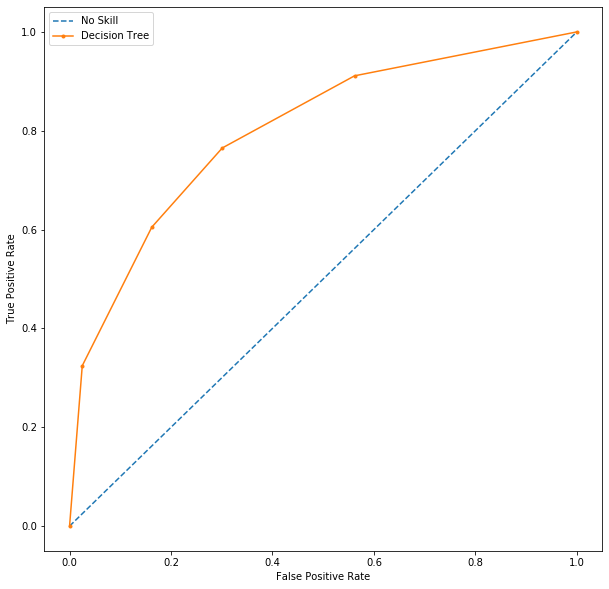

In [65]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
dt_probs = grid_dt.predict_proba(X_test)
# keep probabilities for the positive outcome only
dt_probs = dt_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
# plot the roc curve for the model
plt.figure(figsize=(10,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [66]:
# Dropping the 'ID' attribute from the testing data
test_df_dt= test_df_dt.drop('ID', axis=1)

In [67]:
# Predicting rain forecast labels for test dataset
test_prediction_dt = grid_dt.predict(test_df_dt)

#### Visualizing the decision tree model

- Below we have plotted a decision tree output visualization.

- We have used the best paramaters obtained from the Grid Search to build a new decision tree model that has the best performance

- We have then used this best model to plot a visual representation of the decision tree model. The below visualization shows that the first node split has been made by the algorithm on the 'Humidity' attribute. After that, the tree splits into two more nodes which are split further based on the attributes 'WindGustSpeed' & 'Humidity' respectively. With each split, we can also see the information gain that has been calculated by the decision tree model using the gini index algorithm. Each of the split represents the output class label - 'RainTomorrow' = 'Yes/No'.

In [62]:
# Printing the best hyper-paramaters obtained from grid search
grid_dt.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 25}

In [177]:
# Building a new decision tree model using the best parameters obtained by Grid Search
dt_clf_best_model = DecisionTreeClassifier(criterion= 'gini',
 max_depth= 5,
 max_leaf_nodes= 5,
 min_samples_leaf= 1,
 min_samples_split= 25,
random_state=0)

In [180]:
# Training the data using the best dt model
dt_best = dt_clf_best_model.fit(X_train, y_train)

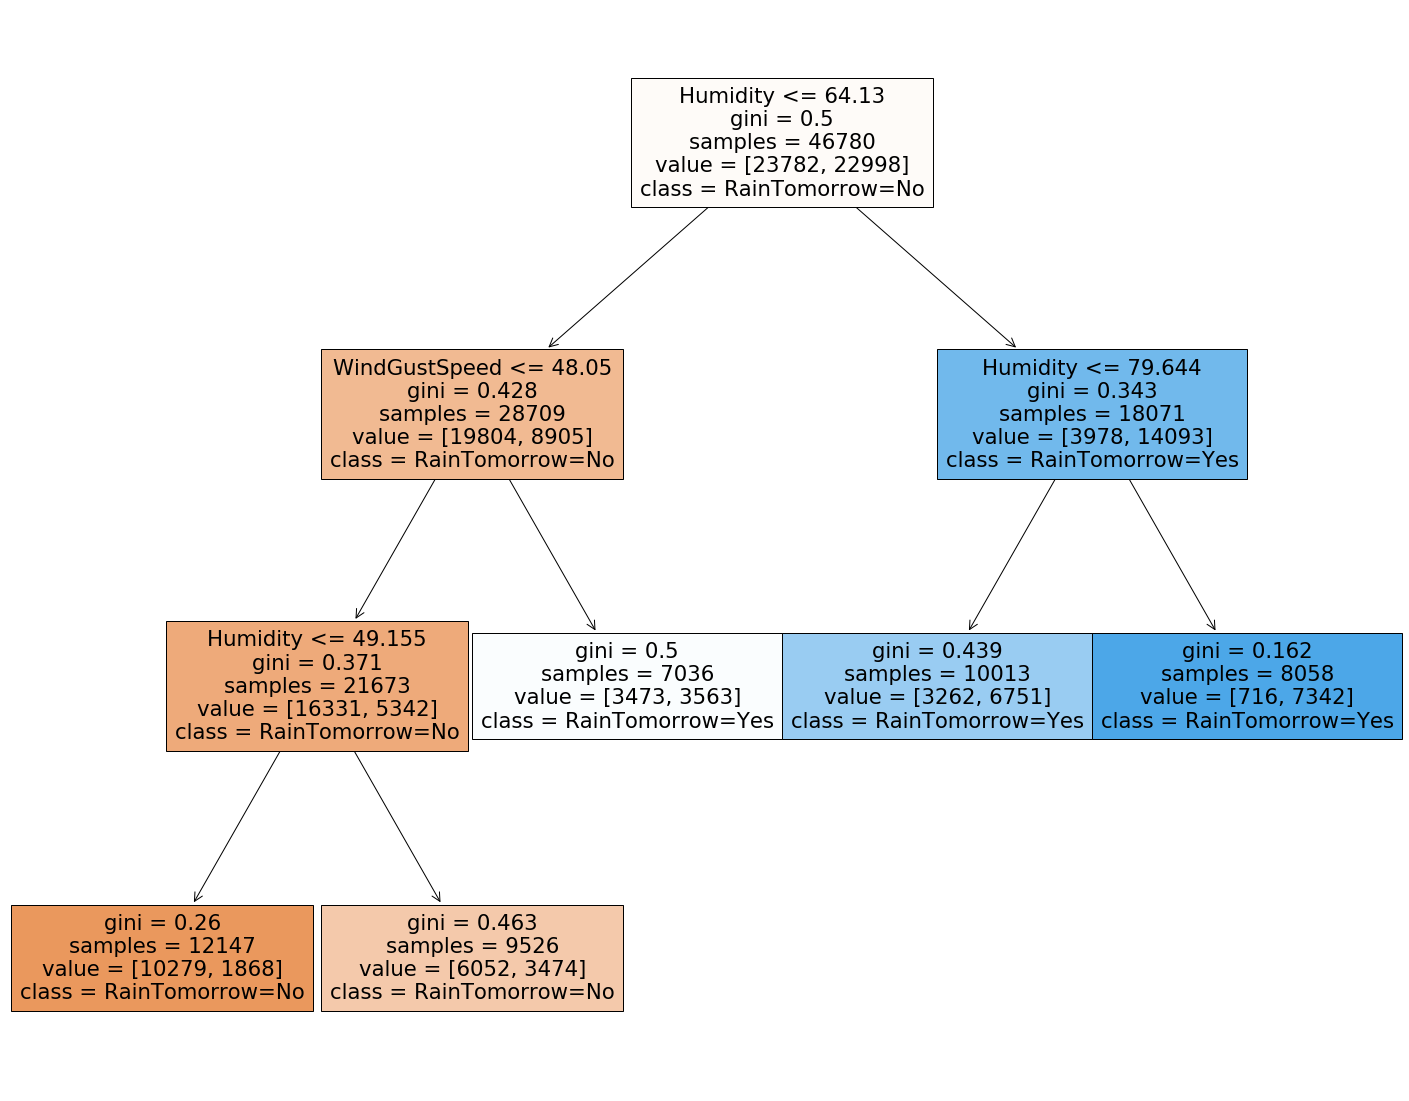

In [183]:
# Plotting the decision tree visual representation 
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_best, 
                   feature_names=train_df_dt.columns,  
                   class_names=['RainTomorrow=No','RainTomorrow=Yes'],
                   filled=True)

## Hierarchical Agglomerative Clustering Model

Performing HAC algorithm:
- Firstly, we have created a copy of our pre-processed train and test dataset to implement the HAC model.

- We have removed all the categorical attributes from the train and test data as doing a One-hot encoding for HAC algorithm will not be beneficial. This is due to the fact that binary coding will produce high density regions which will affect the performance of HAC model. We have dropped 'RainToday' attribute for the same reason. We have also dropped 'ID' attribute from the test data set.

- For HAC, there is no predict function. So, we have trained the model on whole training data set to evaluate the performance of our model. While training the model on train data, we have also removed the target variable 'RainTomorrow' from the train data and stored it in a separate variable. We will use this later to evaluate the labels predicted by our model against the actual 'RainTomorrow' labels and measure the performance of the model 

- We have scaled both the train and test data using MinMax scaler so that all the data is on the same scale. This is an important step as it can significantly improve our model's performance.

- We have fitted the model on the training data and then evaluated the performance of the model by comparing the labels generated by the model against the actual 'RainTomorrow' labels which we removed earlier from the training set

- After this, we used the same above parameters to fit our model on the testing data as HAC does not contain a predict function. This has generated the output labels for rain forecast for the testing data 

- It is not possible to run HAC model on the combined train and test data due to limitation of computational resources.

In [69]:
# Creating a copy of pre-processed train and test data that we will be using to implement HAC model
train_df_hac = df.copy()
test_df_hac = test_df.copy()

In [70]:
# Dropping all the categorical columns, 'RainToday' from the train and test data and dropping 'ID' from test data
train_df_hac.drop(["Location",'WindDir','WindGustDir','RainToday'],axis=1,inplace=True)
test_df_hac.drop(["Location",'WindDir','WindGustDir','RainToday', 'ID'],axis=1,inplace=True)

In [71]:
# Removing the actual labels from training data
actual_training_labels_hac=train_df_hac.pop("RainTomorrow")

In [72]:
# Using MinMax scalar
min_max_scaler_hac = preprocessing.MinMaxScaler()

In [73]:
# Scaling train data
train_df_hac=min_max_scaler_hac.fit_transform(train_df_hac)

In [74]:
# Scaling the test data
test_df_hac = min_max_scaler_hac.transform(test_df_hac)

#### Hyper-parameter tuning for the HAC model:

- n_cluster: The number of clusters to find

- linkage: Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

            - ward: minimizes the variance of the clusters being merged.

            - average: uses the average of the distances of each observation of the two sets.

            - complete or maximum linkage: uses the maximum distances between all observations of the two sets.

            - single: uses the minimum of the distances between all observations of the two sets.


In [75]:
# Building the HAC model with 2 clusters and linkage as 'ward'
hac_model=AgglomerativeClustering(n_clusters=2,linkage="ward")

In [76]:
# Training the HAC model on the whole training dataset
train_hac_model = hac_model.fit(train_df_hac)

#### Interpreting the results

- Below we have classification report for the training set

- We can infer from the classification reports that our HAC model performs averagely on the training data.

- The recall value is 0.42 which represents that our model is able to correctly predict rainfall 42% of the times when it actually rained on that day

- The performance of this model is not that good which can be traced back to the point that we had a large number of missing values present in our dataset in the first place

In [77]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(train_hac_model.labels_,actual_training_labels_hac))

              precision    recall  f1-score   support

           0       0.45      0.44      0.44     26618
           1       0.42      0.42      0.42     25360

    accuracy                           0.43     51978
   macro avg       0.43      0.43      0.43     51978
weighted avg       0.43      0.43      0.43     51978



#### Dendogram plot

- We tried plotting the Dendogram plot for the HAC model in order to better understand how the data points are clustered but we were not able to train a new HAC model required for the dendogram plot due to lack of computational resources

- We tried fitting this model required to plot the dendogram on whole of the training dataset using a 8GB RAM machine. But unfortunately, the training ran for more than 5 hours straight and even then did not complete due to lack of computing power

- We did not try to plot the dendogram using a random sample of the training dataset as that would not have given us the clear picture of how data points are clustered for whole of the dataset

In [80]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# Building a new HAC model for plotting the dendogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(train_df_hac)

In [ ]:
# Plotting the Dendogram plot
print("Below is the dendogram plot of how the data points are clustered")
plt.figure(figsize=(20,10))
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# Fitting the hac model on test dataset aas HAC does not contain a predict function
test_hac_model=AgglomerativeClustering(n_clusters=2).fit(test_df_hac)

In [ ]:
# Predicting rain forecast labels for test dataset
test_prediction_hac = test_hac_model.labels_

## Conclusion

- Below, we have summarized the results for all the three machine learning models that we have implemented for the Rainfall forecast problem

- The below table contains names of all the algorithms that we have implemented, their evaluation metric - Recall scores and the best hyper-parameters for each of the model obtained through the Grid Search

- We can infer from the below table that Decision Tree model is by far the best model to predict the rain forecast problem. DT model has the highest recall score

- We have used the evaluation metric as Recall for predicting the rain forecast. We have selected Recall as the evaluation metric because it is very important for our model to correctly predict rains on the days when it actually rained on that particular day

- K-means and HAC did not perform well, which can be traced back to the fact that there were a lot of missing values in the dataset and the data can be classified more accurrately by drawing linear decision boundaries instead of using two clusters to classify the whole data.

In [169]:
# Creating a summary table for the model names, their recall scores and their best hyper parameters
best_models = pd.DataFrame({"Algorithm":["K-Means","Decision Tree","HAC"], "Recall":[0.54,0.71,0.42],
                            "Best Hyper-parameters":["max_iter:20,n_init:50",
                                               "criterion:gini,max_depth:5,max_leaf_nodes:5,min_samples_leaf:1,min_samples_split:25",
                                               "linkage:ward"]})

In [185]:
# Printing the best_models summary table
best_models

,Algorithm,Recall,Best Hyper-parameters
0,K-Means,0.54,"max_iter:20,n_init:50"
1,Decision Tree,0.71,"criterion:gini,max_depth:5,max_leaf_nodes:5,mi..."
2,HAC,0.42,linkage:ward


## Final Predictions on Test Set 

- We have made a final dataframe containing the test set predictions for all the three algorithms.

- We have also converted this dataframe to a csv that contains 4 columns: 

- ID: contains the ID for each of the data points present in the test set 

- kmeans: contains binary prediction labels made by the K-Means algorithm for each of the data points present in the test set 

- HAC: contains binary prediction labels made by the HAC algorithm for each of the data points present in the test set 

- DT: contains binary prediction labels made by the DT algorithm for each of the data points present in the test set 

In [171]:
# Making the final predictions on the test data set using all the 3 models and storing it in a dataframe
final_prediction_results=pd.DataFrame({"ID":test_df.ID,
                                       "kmeans":test_prediction_kmeans,
                                       "HAC":test_prediction_hac,
                                       "DT":test_prediction_dt})

In [173]:
# Converting the final prediction results to a csv file
final_prediction_results.to_csv("final_prediction_results.csv",index=False)